In [1]:
import torch
from torch_geometric.loader import DataLoader
#from torch_geometric.nn import GNNExplainer
from util.gnnexplainer import GNNExplainer
from datasets import split_data
import pandas as pd
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt

In [2]:
test_list = ['FRH007_LAD.pt', 'FRH007_LCX.pt', 'FRH010_LAD.pt', 'FRH010_RCA.pt',
             'OLV011_LAD.pt', 'OLV011_RCA.pt', 'OLV016_LAD.pt', 'OLV016_LCX.pt',
             'OLV016_RCA.pt', 'OLV035_LAD.pt', 'OLV035_LCX.pt', 'OLV035_RCA.pt',
             'OLV037_LAD.pt', 'OLV037_RCA.pt', 'OLV041_LAD.pt', 'OLV041_LCX.pt',
             'OLV041_RCA.pt', 'OLV048_LAD.pt', 'OLV048_LCX.pt']

In [3]:
# create dictionary for lesion data and artery data
def get_data(data_name):
    data = torch.load("../data/CoordToCnc/"+pt_seg) # all lesions need to be loaded in this folder
    lesion_mask = torch.load("../data/lesions/"+pt_seg) # all data points need to be loaded in here
    return data, lesion_mask

In [4]:
# load trained model
mod = torch.load('model/equiv_gin-9.pt', map_location='cpu').model

In [5]:
# evaluate model
# Sanity check, equiv_gin-9's accuracy is 94.7%
acc, nb_pos, nb_true_pos = 0, 0, 0
for pt_seg in test_list:
    data, _ = get_data(pt_seg)
    pred = mod(data.x, data.edge_index,
                        batch=torch.zeros(len(data.x), dtype=torch.int64),
                        segment=torch.tensor([data.segment]))
    if torch.argmax(pred) == data.y:
        acc +=1
        if data.y ==1:
            nb_true_pos +=1
    if data.y ==1:
        nb_pos +=1
acc=acc/len(test_list)
nb_true_pos = nb_true_pos/nb_pos
print('Nb samples: ', len(test_list))
print('Model accuracy on sample set: ', acc)
print('Nb positive sample: ', nb_pos)
print('accuracy on positive: ', nb_true_pos)

Nb samples:  19
Model accuracy on sample set:  0.9473684210526315
Nb positive sample:  8
accuracy on positive:  0.875


In [43]:
def plot_mask(mask, data_name):
    """ plotting function that plots the mask on
        the point cloud corresponding to data_name """
    data, _ = get_data(data_name)
    
    points = pd.DataFrame(data.x.detach().numpy(), columns=['x', 'y', 'z']) 
    
    fig = px.scatter_3d(points, x='x', y='y', z='z', color=np.absolute(mask))

    fig.update_traces(marker=dict(size=2),
                      selector=dict(mode='markers'))

    fig.show()


def get_lesion_mask(data_name):
    return get_data(data_name)[1]

def get_explainer_mask(explainer, model, data_name):
    
    data, _ = get_data(data_name)
    
    #to avoid using iterator (in order to have consistent indexing)
    data.segment=torch.tensor([data.segment])
    data.batch = torch.zeros(data.x.shape[0], dtype=torch.int64)
    
    # explainer mask:
    feature_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index, segment=data.segment)    

    # from mask defined on edges, we make a mask defined on vertices to visualize on the point cloud:
    vertex_coef = np.zeros(len(data.x))
    for i, e in enumerate(data.edge_index.transpose(0,1)):
        for v in e:
            if edge_mask[i]>vertex_coef[v]: #we take the maximum of the mask on  edges adjacent to that node
                vertex_coef[v] = edge_mask[i]
    return vertex_coef

def dist_les_wrt_explainer(expl_coef, les_coef, thresh_met="mean+std"):
    """ stats about distribution of explainer and distribution of lesion regions"""
    if thresh_met == "mean+std":
        thresh = expl_coef.mean()+expl_coef.std() # this can be tweaked
        stat_counter = [0,0,0,0,0,0]
        gnn_size_count=0
        lesion_counter = [0, 0, 0, 0, 0, 0]
        for i in range(len(expl_coef)):
            lesion_counter[int(les_coef[i])]+=1
            if expl_coef[i]>thresh:
                gnn_size_count+=1
                stat_counter[int(les_coef[i])]+=1
        #return les_coef, expl_coef, stat_counter, np.array(stat_counter)/(gnn_size_count), lesion_counter, np.array(lesion_counter)/len(expl_coef)
        return stat_counter, np.array(stat_counter)/(gnn_size_count), lesion_counter, np.array(lesion_counter)/len(expl_coef)
    else:
        print("unrecognized threshold method")



In [40]:
# initialize explainer model
explainer_mod = GNNExplainer(mod, num_hops=100, epochs=200)

Artery name:  FRH007_LCX.pt
Label:  1
Prediction:  tensor([[0.0144, 0.9856]], grad_fn=<SoftmaxBackward>)


Explain graph: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:26<00:00,  7.45it/s]


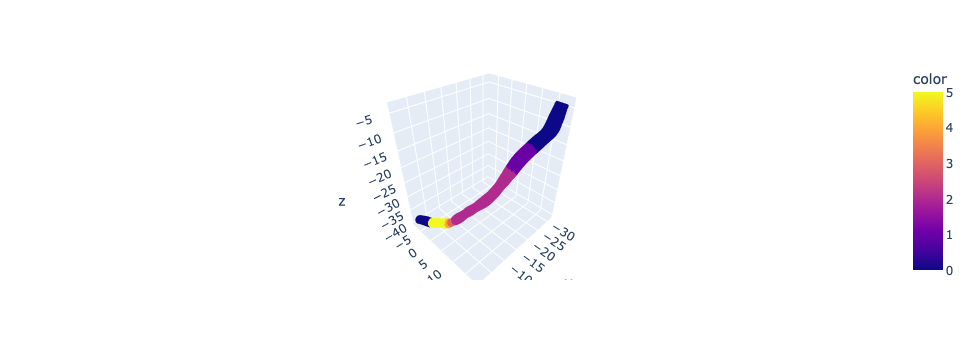

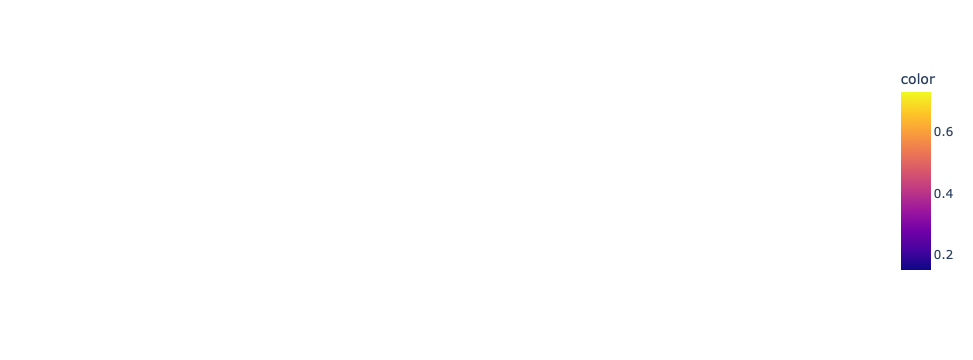

[15, 0, 5, 0, 0, 4] explainer graph location in lesion total
[0.62 0.   0.21 0.   0.   0.17] explainer graph location in lesion %
[0.29 0.09 0.44 0.05 0.02 0.11]  for lesion %
[1855, 579, 2763, 302, 115, 688] lesion counts total



In [41]:
i=1
pt_seg = test_list[i]
print("Artery name: ", pt_seg)
data, _ = get_data(pt_seg)
print("Label: ", data.y)
print("Prediction: ", mod(data.x, data.edge_index, torch.zeros(len(data.x), dtype=int), torch.tensor([data.segment])))
expl_mask = get_explainer_mask(explainer=explainer_mod, model=mod, data_name=test_list[i])
les_coef, expl_coef, stat_counter, averages, lesion_counter, lesion_averages = dist_les_wrt_explainer(expl_mask, get_lesion_mask(test_list[i]))

plot_mask(get_lesion_mask(pt_seg), pt_seg)
plot_mask(expl_mask, pt_seg)

print(stat_counter, "explainer graph location in lesion total")
print(np.around(averages, decimals=2), "explainer graph location in lesion %")
print(np.around(lesion_averages, decimals=2), " for lesion %")
print(lesion_counter, "lesion counts total")
print("")

In [8]:
# this trains explainer models and saves explaoiner masks

for pt_seg in test_list:
    expl_mask = get_explainer_mask(explainer=explainer_mod, model=mod, data_name=pt_seg)
    torch.save(expl_mask, "expl_coef/equiv_gin-9/num_hops_100/"+pt_seg)
    

Explain graph: 100%|██████████████████████████| 200/200 [00:26<00:00,  7.48it/s]


In [33]:
#i = 9
i=1

FRH007_LCX.pt


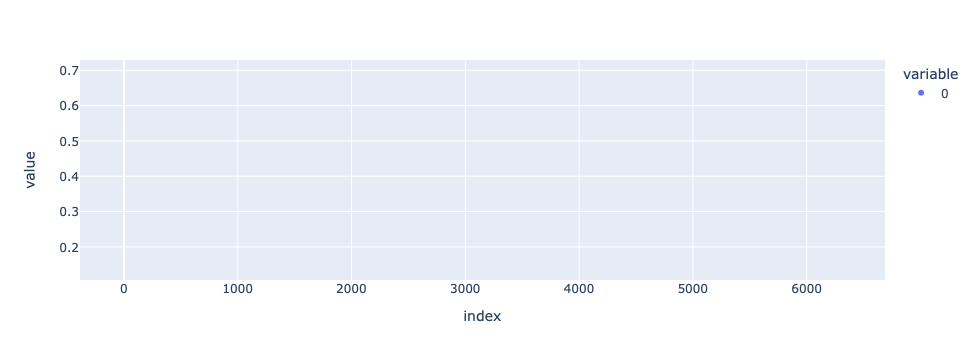

In [34]:
pt_seg = test_list[i]
print(pt_seg)
expl_mask = torch.load("expl_coef/equiv_gin-9/"+pt_seg)
px.scatter(np.flip(np.sort(expl_mask)))

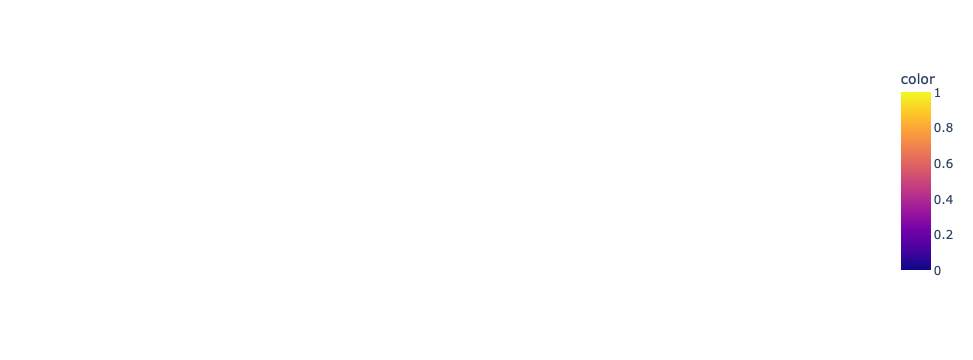

In [35]:
new_mask = np.where(expl_mask > 0.16, np.ones(len(expl_mask)), np.zeros(len(expl_mask)))
les_coef = get_lesion_mask(pt_seg)
plot_mask(new_mask, pt_seg)

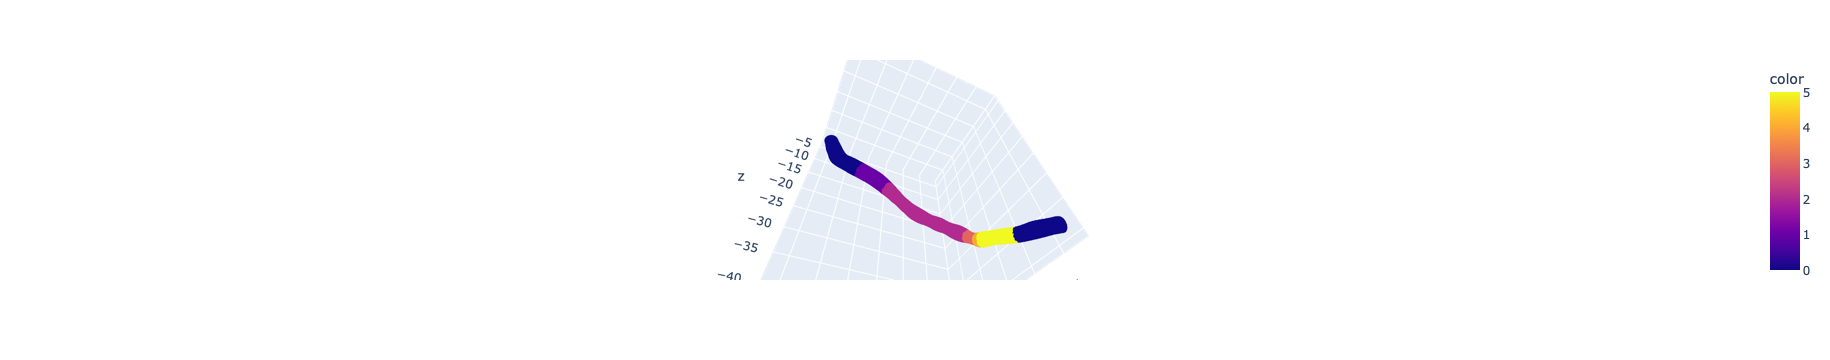

In [36]:
plot_mask(les_coef, pt_seg)

In [37]:
data, _ = get_data(pt_seg)
print("Label: ", data.y)
print("Prediction: ", mod(data.x, data.edge_index, torch.zeros(len(data.x), dtype=int), torch.tensor([data.segment])))

stat_counter, averages, lesion_counter, lesion_averages = dist_les_wrt_explainer(new_mask, les_coef)

print(stat_counter, "explainer graph location in lesion total")
print(np.around(averages, decimals=2), "explainer graph location in lesion %")
print(np.around(lesion_averages, decimals=2), " for lesion %")
print(lesion_counter, "lesion counts total")
print("")

Label:  1
Prediction:  tensor([[0.0144, 0.9856]], grad_fn=<SoftmaxBackward>)
[10, 5, 10, 0, 0, 4] explainer graph location in lesion total
[0.34 0.17 0.34 0.   0.   0.14] explainer graph location in lesion %
[0.29 0.09 0.44 0.05 0.02 0.11]  for lesion %
[1855, 579, 2763, 302, 115, 688] lesion counts total



In [47]:
for i, pt_seg in enumerate(test_list):
    if i != 11:
        print(i)
        print(pt_seg)
        expl_mask = torch.load("expl_coef/equiv_gin-9/"+pt_seg)
        les_coef = get_lesion_mask(pt_seg)

        data, _ = get_data(pt_seg)
        print("Label: ", data.y)
        print("Prediction: ", mod(data.x, data.edge_index, torch.zeros(len(data.x), dtype=int), torch.tensor([data.segment])))

        stat_counter, averages, lesion_counter, lesion_averages = dist_les_wrt_explainer(expl_mask, les_coef)

        #print(stat_counter, "explainer graph location in lesion total")
        print(np.around(averages, decimals=2), "explainer graph location in lesion %")
        print(np.around(lesion_averages, decimals=2), " for lesion %")
        #print(lesion_counter, "lesion counts total")
        print("")

0
FRH007_LAD.pt
Label:  0
Prediction:  tensor([[0.9285, 0.0715]], grad_fn=<SoftmaxBackward>)
[1. 0. 0. 0. 0. 0.] explainer graph location in lesion %
[0.77 0.04 0.03 0.03 0.01 0.1 ]  for lesion %

1
FRH007_LCX.pt
Label:  1
Prediction:  tensor([[0.0144, 0.9856]], grad_fn=<SoftmaxBackward>)
[0.34 0.17 0.34 0.   0.   0.14] explainer graph location in lesion %
[0.29 0.09 0.44 0.05 0.02 0.11]  for lesion %

2
FRH010_LAD.pt
Label:  0
Prediction:  tensor([[0.6713, 0.3287]], grad_fn=<SoftmaxBackward>)
[0.6 0.  0.  0.  0.4 0. ] explainer graph location in lesion %
[0.43 0.06 0.03 0.06 0.34 0.08]  for lesion %

3
FRH010_RCA.pt
Label:  1
Prediction:  tensor([[0.0946, 0.9054]], grad_fn=<SoftmaxBackward>)
[0.65 0.   0.02 0.33 0.   0.  ] explainer graph location in lesion %
[0.74 0.08 0.01 0.05 0.03 0.1 ]  for lesion %

4
OLV011_LAD.pt
Label:  1
Prediction:  tensor([[7.3019e-06, 9.9999e-01]], grad_fn=<SoftmaxBackward>)
[0.56 0.24 0.   0.   0.1  0.1 ] explainer graph location in lesion %
[0.41 0.1  0